# Week 2 Missing Data and Smoothing Models
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [1]:
import math
import scipy as sp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss

import warnings
warnings.filterwarnings('ignore')

## 1. 20 pts - Exploratory Data Analysis

### 1.1 - 5 pts Plot the data

In [2]:
df = pd.read_csv('hw2_data.csv')

In [3]:
df

,Date,IWM,QQQ,SPY
0,2000-05-26,34.800865,67.670738,93.363678
1,2000-05-30,NaN,NaN,NaN
2,2000-05-31,NaN,NaN,NaN
3,2000-06-01,37.036850,76.048004,98.310966
4,2000-06-02,38.963646,81.487755,100.023491
...,...,...,...,...
4967,2020-02-26,152.328430,215.254486,305.789459
4968,2020-02-27,146.964890,204.475845,292.055939
4969,2020-02-28,NaN,NaN,NaN
4970,2020-03-02,NaN,NaN,NaN


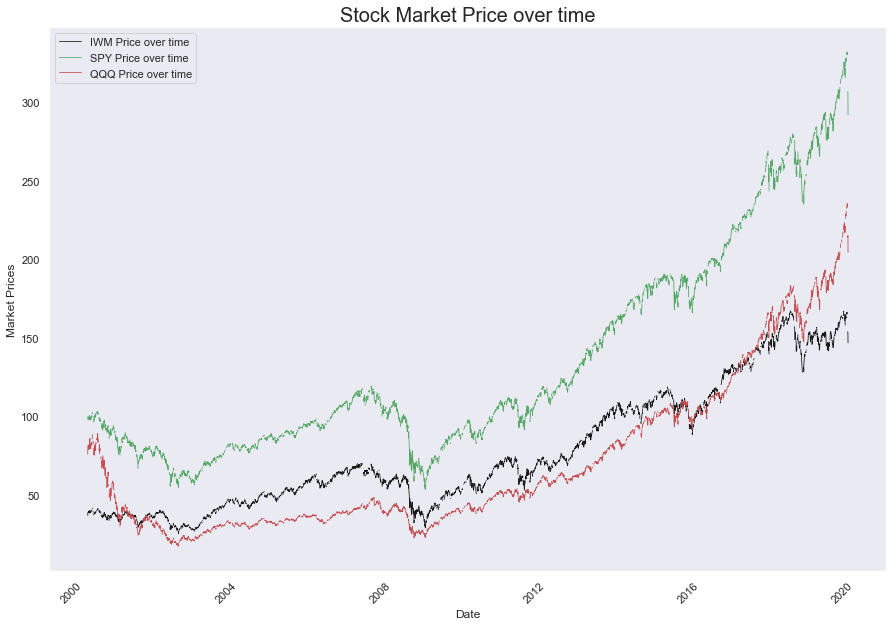

In [4]:
x = df['Date']
x = pd.to_datetime(x)

y = df['IWM']
z = df['SPY']
v = df['QQQ']

plt.figure(figsize=(15,10))  
plt.plot(x, y, color = 'k',label = "IWM Price over time", ls = '-', lw = 0.8)
plt.plot(x, z, color = 'g',label = "SPY Price over time", ls = '-', lw = 0.8)
plt.plot(x, v, color = 'r',label = "QQQ Price over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Market Prices')
plt.title('Stock Market Price over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

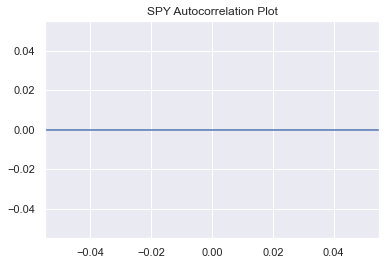

In [5]:
p = plot_acf(df['SPY'], lags=40, title='SPY Autocorrelation Plot')

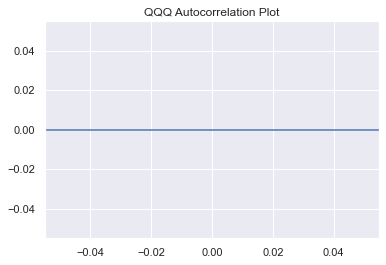

In [6]:
p = plot_acf(df['QQQ'], lags=40, title='QQQ Autocorrelation Plot')

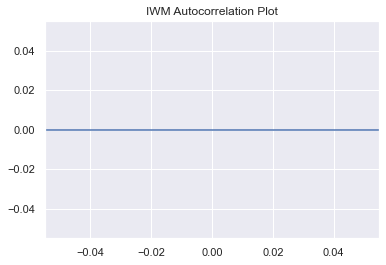

In [7]:
p = plot_acf(df['IWM'], lags=40, title='IWM Autocorrelation Plot')

### 1.2 5 pts From looking at the plot, does there appear to be missing data? 

- When observing the plot in 1.1, while it is very faint there does seem to be gaps and discontinuations in the lines for each of the stocks. The easiest way to realize there is missing data is to look at the most recent data-- that is for stock prices around 2020.
- This cumulative plot of the data over multiple years makes the missing data not as noticeable, but I would propose that if you redo the plot for individual years the missing data would be more obvious.

### 1.3 5 pts How many NA values appear in each time series? What percentage of data is missing? Give one reason why we might be missing data in this pattern?

- We run exploratory code to find missing values. We find 897 NA values appearing in each time series.
- In similar fashion we run code and compute roughly 18% of the data is comprised of these missing values.
- One reason why we might be missing data in this pattern is simple human errors. For example, these values may have been missed during manual data entry or manual compilation/binding of multiple datasets. This highlights the value of having quality checks during the data accumulation process.

In [8]:
df.isnull().sum()

Date      0
IWM     897
QQQ     897
SPY     897
dtype: int64

In [9]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

Date     0.00000
IWM     18.04103
QQQ     18.04103
SPY     18.04103
dtype: float64

<AxesSubplot:>

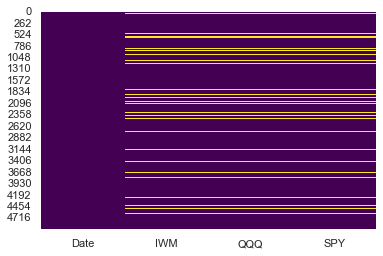

In [10]:
# Visualizing the missing values
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

### 1.4 5 pts Describe one business case where you would not proceed with this much missing data. Describe one business case where you would proceed with this much missing data.

- One business case where you would not proceed with 18% of your data missing is if there are specific reasons why it's missing. This is NMAR missing data, or data that is Not Missing at Random. For example, if you are dealing with survey data regarding favorite music genres by age groups, and responses from individuals ages 30 to 45 are missing, you will have largely skewed or biased results.

- One business case where you would/could proceed with 18% of your data missing is if it is 'missing completely at random', or MCAR. The missing of these data is unrelated or independent of the remaining variables. It is not possible to predict these values with the rest of the variable data. One scenario where this could happen is if sample data is mishandled or incorrectly processed, thus unable to be used in the dataset. In this case, deciding to exclude this sample would not lead to biased estimates.

- In general, missing data decreases the predictive power behind models you create. If you have missing data, your estimates of parameters are likely to have biased results. It is very difficult to make accurate or confident statements about your predictions without addressing the presence of missing data.

## 2. 20 pts - Missing Data

### 2.1 5 pts Create a forward fill
- The value of the next row will be used to fill the missing value

In [11]:
forward_filled = df.fillna(method='ffill')
forward_filled

,Date,IWM,QQQ,SPY
0,2000-05-26,34.800865,67.670738,93.363678
1,2000-05-30,34.800865,67.670738,93.363678
2,2000-05-31,34.800865,67.670738,93.363678
3,2000-06-01,37.036850,76.048004,98.310966
4,2000-06-02,38.963646,81.487755,100.023491
...,...,...,...,...
4967,2020-02-26,152.328430,215.254486,305.789459
4968,2020-02-27,146.964890,204.475845,292.055939
4969,2020-02-28,146.964890,204.475845,292.055939
4970,2020-03-02,146.964890,204.475845,292.055939


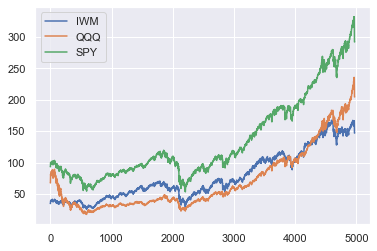

In [12]:
forward_filled.plot()
plt.show()

### 2.2 Create a backward fill
-  the value of the previous row to fill the missing value

In [13]:
backward_filled = df.fillna(method='bfill')
backward_filled

,Date,IWM,QQQ,SPY
0,2000-05-26,34.800865,67.670738,93.363678
1,2000-05-30,37.036850,76.048004,98.310966
2,2000-05-31,37.036850,76.048004,98.310966
3,2000-06-01,37.036850,76.048004,98.310966
4,2000-06-02,38.963646,81.487755,100.023491
...,...,...,...,...
4967,2020-02-26,152.328430,215.254486,305.789459
4968,2020-02-27,146.964890,204.475845,292.055939
4969,2020-02-28,NaN,NaN,NaN
4970,2020-03-02,NaN,NaN,NaN


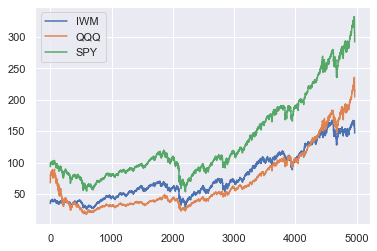

In [14]:
backward_filled.plot()
plt.show()

### 2.3 Create a moving average fill

- We're also able to construct a moving average fill with the 'forward_filled' dataset as there are no missing values.
- Alternatively, we could also find a moving average fill by first dropping NAs, and then using the 'df.rolling()' function that helps us to make calculations on a rolling window. On the rolling window, we will use .mean() function to calculate the mean of each window.

In [15]:
import numpy as np
import pandas as pd

def apply_mean_imputer(x, period):
    
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    
    results = []
    for i in range(1, len(x)+1):
        slice_of_x = x.iloc[ max(0, i-period) :i]
        mean_of_x = slice_of_x.mean()
        results.append(mean_of_x)
    
    missing_results = pd.Series(results, index=x.index)
    missing_results = np.where(x.isnull(), missing_results, x )
    missing_results = pd.Series(missing_results, index=x.index)
    return missing_results

In [23]:
df_moving_avg = df.copy()
df_moving_avg

,Date,IWM,QQQ,SPY
0,2000-05-26,34.800865,67.670738,93.363678
1,2000-05-30,NaN,NaN,NaN
2,2000-05-31,NaN,NaN,NaN
3,2000-06-01,37.036850,76.048004,98.310966
4,2000-06-02,38.963646,81.487755,100.023491
...,...,...,...,...
4967,2020-02-26,152.328430,215.254486,305.789459
4968,2020-02-27,146.964890,204.475845,292.055939
4969,2020-02-28,NaN,NaN,NaN
4970,2020-03-02,NaN,NaN,NaN


In [26]:
imputed_QQQ = apply_mean_imputer(df_moving_avg['QQQ'], 5)
imputed_QQQ

0        67.670738
1        67.670738
2        67.670738
3        76.048004
4        81.487755
           ...    
4967    215.254486
4968    204.475845
4969    211.293696
4970    211.293696
4971    209.865166
Length: 4972, dtype: float64

In [20]:
imputed_IWM = apply_mean_imputer(df['IWM'], 5)
imputed_IWM

0        34.800865
1        34.800865
2        34.800865
3        37.036850
4        38.963646
           ...    
4967    152.328430
4968    146.964890
4969    151.135437
4970    151.135437
4971    149.646660
Length: 4972, dtype: float64

In [30]:
moving_avg_ff = forward_filled
moving_avg_ff['5_day_avg'] = moving_avg_ff['QQQ'].rolling(5).mean()
moving_avg_ff

,Date,IWM,QQQ,SPY,5_day_avg
0,2000-05-26,34.800865,67.670738,93.363678,NaN
1,2000-05-30,34.800865,67.670738,93.363678,NaN
2,2000-05-31,34.800865,67.670738,93.363678,NaN
3,2000-06-01,37.036850,76.048004,98.310966,NaN
4,2000-06-02,38.963646,81.487755,100.023491,72.109595
...,...,...,...,...,...
4967,2020-02-26,152.328430,215.254486,305.789459,225.951569
4968,2020-02-27,146.964890,204.475845,292.055939,220.156564
4969,2020-02-28,146.964890,204.475845,292.055939,214.361560
4970,2020-03-02,146.964890,204.475845,292.055939,208.566556


In [31]:
forward_filled['5_day_avg'] = forward_filled['QQQ'].rolling(5).mean()
forward_filled

,Date,IWM,QQQ,SPY,5_day_avg
0,2000-05-26,34.800865,67.670738,93.363678,NaN
1,2000-05-30,34.800865,67.670738,93.363678,NaN
2,2000-05-31,34.800865,67.670738,93.363678,NaN
3,2000-06-01,37.036850,76.048004,98.310966,NaN
4,2000-06-02,38.963646,81.487755,100.023491,72.109595
...,...,...,...,...,...
4967,2020-02-26,152.328430,215.254486,305.789459,225.951569
4968,2020-02-27,146.964890,204.475845,292.055939,220.156564
4969,2020-02-28,146.964890,204.475845,292.055939,214.361560
4970,2020-03-02,146.964890,204.475845,292.055939,208.566556


In [28]:
print('Dataset before :', len(df))
df.dropna(subset = ['QQQ'],how='any',inplace=True)
print('Dataset after :', len(df))
print('missing values :',df['QQQ'].isnull().sum())

Dataset before : 4972
Dataset after : 4075
missing values : 0


In [29]:
df['5_day_avg'] = df['QQQ'].rolling(5).mean()
df

,Date,IWM,QQQ,SPY,5_day_avg
0,2000-05-26,34.800865,67.670738,93.363678,NaN
3,2000-06-01,37.036850,76.048004,98.310966,NaN
4,2000-06-02,38.963646,81.487755,100.023491,NaN
6,2000-06-06,39.201530,79.420624,99.093246,NaN
8,2000-06-08,39.153946,81.161362,99.389206,77.157697
...,...,...,...,...,...
4962,2020-02-19,166.033051,235.638428,332.137360,233.588098
4963,2020-02-20,166.437286,233.450867,330.772919,233.689517
4966,2020-02-25,154.112991,214.150757,306.918335,229.990576
4967,2020-02-26,152.328430,215.254486,305.789459,226.379138


### 2.4 Create an interpolation

In [32]:
df_interpol = df
df_interpol['interpolation'] = df_interpol['QQQ'].interpolate()
df_interpol

,Date,IWM,QQQ,SPY,5_day_avg,interpolation
0,2000-05-26,34.800865,67.670738,93.363678,NaN,67.670738
3,2000-06-01,37.036850,76.048004,98.310966,NaN,76.048004
4,2000-06-02,38.963646,81.487755,100.023491,NaN,81.487755
6,2000-06-06,39.201530,79.420624,99.093246,NaN,79.420624
8,2000-06-08,39.153946,81.161362,99.389206,77.157697,81.161362
...,...,...,...,...,...,...
4962,2020-02-19,166.033051,235.638428,332.137360,233.588098,235.638428
4963,2020-02-20,166.437286,233.450867,330.772919,233.689517,233.450867
4966,2020-02-25,154.112991,214.150757,306.918335,229.990576,214.150757
4967,2020-02-26,152.328430,215.254486,305.789459,226.379138,215.254486


## 3. 60 pts - Smoothing Methods
- Choose one filling method and apply to SPY time series. 
- Use pd.core.indexes.period.PeriodIndex to convert to period index
    -index = pd.core.indexes.period.PeriodIndex(interpolated_df.index.tolist(), freq='b')
- Split using temporal train and test.
- Use ForecastingHorizon from sktime.forecasting.all
    - forecasting_index = ForecastingHorizon(y_test.index, is_relative=False)

For each of the following methods return
- Labeled plot of y_test and y_pred overlayed on top of each other
- sMAPE for the test set

Use a for loop or create a function to avoid repetative code

In [62]:
df = pd.read_csv('hw2_data.csv')

In [63]:
df.set_index('Date', inplace = True)

In [64]:
df_SPY = apply_mean_imputer(df['SPY'], 5)

In [65]:
df_SPY

Date
2000-05-26     93.363678
2000-05-30     93.363678
2000-05-31     93.363678
2000-06-01     98.310966
2000-06-02    100.023491
                 ...    
2020-02-26    305.789459
2020-02-27    292.055939
2020-02-28    301.587911
2020-03-02    301.587911
2020-03-03    298.922699
Length: 4972, dtype: float64

In [66]:
len(df_SPY)

4972

In [67]:
df_SPY.dropna(inplace = True)

In [68]:
type(df_SPY)

pandas.core.series.Series

In [70]:
df_SPY.index = pd.core.indexes.period.PeriodIndex(df_SPY.index.tolist(), freq='b')
df_SPY.index

PeriodIndex(['2000-05-26', '2000-05-30', '2000-05-31', '2000-06-01',
             '2000-06-02', '2000-06-05', '2000-06-06', '2000-06-07',
             '2000-06-08', '2000-06-09',
             ...
             '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-24',
             '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
             '2020-03-02', '2020-03-03'],
            dtype='period[B]', length=4971)

In [71]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(df_SPY)

### 3.1 10pts Simple exponential smoothing

### 3.2 10pts Holt additive trend

### 3.3 10pts Holt multiplicative trend

### 3.4 10pts Holt Winters additive trend and additive seasonality

### 3.5 10pts Holt Winters multiplicative trend and multiplicative seasonality

### 3.6 10pts Which is the best model, why is it working better? In does it make sense to model stock price data using this method?